### Exercise 10.3

In this exercise, we add advection to the last exercise.

In [1]:
import numpy as np
import sys
from matplotlib import pyplot as plt
import time
import scipy.sparse as sparse
import scipy.sparse.linalg
ROOTDIR = '/home/lochy/Documents/Subject/ucd_geology/Gel298_winter/jupyter_notebooks'
sys.path.append('%s/python_scripts' % ROOTDIR)
from GMesh2d import MESH2D
from GHeatConservationSolver import IMPLICIT_SOLVER
from GMarker import MARKER 

#### Initiate a 2d mesh

This MESH2D class is defined in "python_scripts/GMesh2d.py". 
Here, we use a regular grid of 51 × 31 points. The model size is 1000 × 1500 km2 (i.e. 1 000 000 × 1 500 000 m2). 

In [2]:
# initiate mesh
xsize = 1000000.0 # Model size, m
ysize = 1500000.0
xnum = 41   # Number of nodes
ynum = 61
xs = np.linspace(0.0, xsize, xnum) # construct xs
ys = np.linspace(0.0, ysize, ynum) # construct ys
Mesh2d = MESH2D(xs, ys)

#### Read in the initial temperature

The initial setup corresponds to a background temperature of 1000 K with a rectangular thermal wave (1300 K) in the middle (‘wave’ means sharp perturbation of the temperature field).
Moreover, we assign the thermal parameters accordingly here.

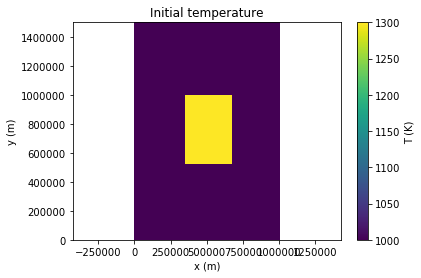

In [3]:
# initial temperature
def rectangular_wave_temperature(x, y, xsize, ysize):
    '''
    temperature profile of a retangular wave in the middle
    '''
    dx = xsize / 3.0
    dy = ysize / 3.0
    if type(x) == float and type(y) == float:
      assert(x >= 0 and x <= xsize and y >= 0 and y <= ysize)
      if x > (xsize - dx) / 2.0 and x < (xsize + dx) / 2.0\
        and y > (ysize - dy) / 2.0 and y < (ysize + dy) / 2.0:
        T = 1300.0
      else:
        T = 1000.0
    elif type(x) == np.ndarray and type(y) == np.ndarray:
      assert(x.shape == y.shape)
      mask = (x > (xsize - dx) / 2.0) & (x < (xsize + dx) / 2.0)\
        & (y > (ysize - dy) / 2.0) & (y < (ysize + dy) / 2.0)
      T = np.ones(x.shape) * 1000.0
      T[mask] = 1300.0
    else:
      raise TypeError("Type of x or y is wrong (either float or numpy.ndarray")
    return T


def rectangular_wave_density(x, y, xsize, ysize):
    '''
    temperature profile of a retangular wave in the middle
    '''
    dx = xsize / 3.0
    dy = ysize / 3.0
    if type(x) == float and type(y) == float:
      assert(x >= 0 and x <= xsize and y >= 0 and y <= ysize)
      if x > (xsize - dx) / 2.0 and x < (xsize + dx) / 2.0\
        and y > (ysize - dy) / 2.0 and y < (ysize + dy) / 2.0:
        rho = 3300.0
      else:
        rho = 3200.0
    elif type(x) == np.ndarray and type(y) == np.ndarray:
      assert(x.shape == y.shape)
      mask = (x > (xsize - dx) / 2.0) & (x < (xsize + dx) / 2.0)\
        & (y > (ysize - dy) / 2.0) & (y < (ysize + dy) / 2.0)
      rho = np.ones(x.shape) * 3200.0
      rho[mask] = 3300.0
    else:
      raise TypeError("Type of x or y is wrong (either float or numpy.ndarray")
    return rho


def rectangular_wave_thermal_capacity(x, y, xsize, ysize):
    '''
    temperature profile of a retangular wave in the middle
    '''
    dx = xsize / 3.0
    dy = ysize / 3.0
    if type(x) == float and type(y) == float:
      assert(x >= 0 and x <= xsize and y >= 0 and y <= ysize)
      if x > (xsize - dx) / 2.0 and x < (xsize + dx) / 2.0\
        and y > (ysize - dy) / 2.0 and y < (ysize + dy) / 2.0:
        cp = 1100.0
      else:
        cp = 1000.0
    elif type(x) == np.ndarray and type(y) == np.ndarray:
      assert(x.shape == y.shape)
      mask = (x > (xsize - dx) / 2.0) & (x < (xsize + dx) / 2.0)\
        & (y > (ysize - dy) / 2.0) & (y < (ysize + dy) / 2.0)
      cp = np.ones(x.shape) * 1000.0
      cp[mask] = 1100.0
    else:
      raise TypeError("Type of x or y is wrong (either float or numpy.ndarray")
    return cp


def rectangular_wave_thermal_conductivity(x, y, xsize, ysize):
    '''
    temperature profile of a retangular wave in the middle
    '''
    dx = xsize / 3.0
    dy = ysize / 3.0
    if type(x) == float and type(y) == float:
      assert(x >= 0 and x <= xsize and y >= 0 and y <= ysize)
      if x > (xsize - dx) / 2.0 and x < (xsize + dx) / 2.0\
        and y > (ysize - dy) / 2.0 and y < (ysize + dy) / 2.0:
        k = 10.0
      else:
        k = 3.0
    elif type(x) == np.ndarray and type(y) == np.ndarray:
      assert(x.shape == y.shape)
      mask = (x > (xsize - dx) / 2.0) & (x < (xsize + dx) / 2.0)\
        & (y > (ysize - dy) / 2.0) & (y < (ysize + dy) / 2.0)
      k = np.ones(x.shape) * 3.0
      k[mask] = 10.0
    else:
      raise TypeError("Type of x or y is wrong (either float or numpy.ndarray")
    return k


xxs, yys = np.meshgrid(xs, ys)
Ts_init = rectangular_wave_temperature(xxs, yys, xsize, ysize)
rhos = rectangular_wave_density(xxs, yys, xsize, ysize)
cps = rectangular_wave_thermal_capacity(xxs, yys, xsize, ysize)
thermal_conductivities = rectangular_wave_thermal_conductivity(xxs, yys, xsize, ysize)


# plot
fig, ax = plt.subplots()
h = ax.pcolor(xxs, yys, Ts_init)
ax.set_title('Initial temperature')
ax.set_xlabel('x (m)')
ax.set_ylabel('y (m)')
ax.invert_yaxis()
ax.axis('equal')
ax.set_xlim([0.0, xsize])
ax.set_ylim([0.0, ysize])
fig.colorbar(h, ax=ax, label='T (K)')

#### Solve the problem

The limit of time step is given by $t_m = \frac{\Delta x^2}{2\kappa}$, thus we first output this value below.

In [4]:
year = 365 * 24 * 3600.0
# use variable thermal parameters
kappa = 3.0 / (3200.0 * 1000.0)  # use the given parameter, derive the smalles kappa manually
dt_m = (xsize / (xnum-1.0))**2.0 / (2*kappa)
print("Limit on time step: %.4e year" % (dt_m / year))

Limit on time step: 1.0570e+07 year


With this estimation, we first test a scenario where the time increment is choosen as $0.6 t_m$

In [ ]:
# load the marker
Marker = MARKER(Mesh2d, 100, 150)

In [ ]:
scaling1 = 1e-6 / (xsize/xnum)**2.0 * 1000.0  # scaling factor, kappa / dx^2.0 * T
dt = dt_m / 3.0  # what Geyra used in his script.
# dt = 1.0  # debug: with this, the temperature profile should be the initial profile
total_step = 20
# initiate solver
HCSolver = IMPLICIT_SOLVER(Mesh2d)
HCSolver.initial_temperature(Ts_init)  # use the rectangular perturbation as the initial temperature
HCSolver.thermal_profile(rhos, cps, thermal_conductivities)  # load the thermal parameters as well
for step in range(total_step):
    # assemble and solve
    HCSolver.assemble(dt, scaling=scaling1)
    HCSolver.solve()
    # export and plot
    xxs, yys, Ts = HCSolver.export()
    t = HCSolver.get_time()
    fig, ax = plt.subplots()
    h = ax.pcolor(xxs, yys, Ts)
    ax.set_title('Temperature, t = %.4e year' % (t/year))
    ax.set_xlabel('x (m)')
    ax.set_ylabel('y (m)')
    ax.set_xlim([0.0, xsize])
    ax.set_ylim([0.0, ysize])
    ax.axis('equal')
    ax.invert_yaxis()
    fig.colorbar(h, ax=ax, label='T (K)')